# Lecture 16 - Model Selection, Hyperparameter Tuning

[![View notebook on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/avakanski/Fall-2025-Applied-Data-Science-with-Python/blob/main/docs/Lectures/Theme_3-Model_Engineering/Lecture_16-Model_Selection/Lecture_16-Model_Selection.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/avakanski/Fall-2025-Applied-Data-Science-with-Python/blob/main/docs/Lectures/Theme_3-Model_Engineering/Lecture_16-Model_Selection/Lecture_16-Model_Selection.ipynb)

<a id='top'></a>

- [16.1 Model Selection](#16.1-model-selection)
- [16.2 Evaluate the Impact of the Learning Rate](#16.2-evaluate-the-impact-of-the-learning-rate)
- [16.3 Callbacks](#16.3-callbacks)
    - [16.3.1 Early Stopping](#16.3.1-early-stopping)
    - [16.3.2 Save Checkpoint](#16.3.2-save-checkpoint)
    - [16.3.3 Reduce Learning Rate on Plateau](#16.3.3-reduce-learning-rate-on-plateau)
    - [16.3.4 Learning Rate Scheduler](#16.3.4-learning-rate-scheduler)
- [16.4 Grid Search](#16.4-grid-search)
- [16.5 Keras Tuner](#16.5-keras-tuner)    
- [16.6 AutoML](#16.6-autoML)
- [References](#references)

## 16.1 Model Selection <a name='16.1-model-selection'></a>

**Model selection** in Machine Learning refers to selecting one final model for a given task, e.g., a model that will be deployed in production. In general, selecting the "best" final model should be based not only on the obtained values of relevant performance metrics (accuracy, specificity, sensitivity), but also based on other considerations, such as computational expense, available resources, model complexity, maintainability, and similar factors.

An important phase in selecting a candidate ML model is **hyperparameter tuning**. **Hyperparameters** (also called *tuning parameters*) are a set of values that control the model's complexity and performance, and they are chosen (tuned) by the user. Note again that the **parameters (weights)** of an ML model are updated iteratively during training, whereas the hyperparameters stay constant and are not updated during training.

In the lecture on scikit-learn, we studied hyperparameter tuning of conventional ML models (such as Linear Regression, k-Nearest Neighbors, Decision Trees, etc.). For this purpose, we used Grid Search and Random Search to explore different combinations of hyperparameter values and to select an optimal set of values for a given performance metric. In our introductory lectures on Artificial Neural Networks (ANNs), we haven't discussed yet how to tune their hyperparameters. That question remained hanging in the air of the pleasant autumn evenings, and it will be the focus of this lecture. Namely, ANNs are more sensitive to hyperparameter tuning than conventional ML models. We saw that even if we use default values for the models in scikit-learn without any hyperparameter tuning, the models can still achieve solid performance. This is rarely the case with ANNs, as they usually require at least some hyperparameter tuning.

Another important aspect of model selection is **performance evaluation**. It can involve exploring various techniques for data preprocessing (e.g., different feature scaling and encoding techniques) and evaluating different feature engineering strategies (e.g., techniques for filling missing data). In addition, it is particularly important to evaluate candidate models on unseen data during training, which is typically achieved by splitting the available data into training and test datasets. We also learned that *k-fold cross-validation* can be used to draw folds from the available data, and evaluate the models on multiple  folds by resampling the available data. With k-fold cross-validation, each data point appears in only one test fold when evaluating model performance.

Finally, note that *hyperparameter tuning* should not be confused with *model fine-tuning* which refers to transfer learning from a model that is pretrained on a large dataset and fine-tuning its parameters on a smaller domain-specific dataset.

### Hyperparameters in Neural Networks

Let's examine again the ConvNet that we used in a previous lecture to classify images in the CIFAR-10 dataset, and identify the hyperparameters of the model.

```
# define the layers in the model
inputs = Input(shape=(32, 32, 3))
conv1a = Conv2D(filters=32, kernel_size=3, padding='same')(inputs)
conv1b = Conv2D(filters=32, kernel_size=3, padding='same')(conv1a)
pool1 = MaxPooling2D()(conv1b)
conv2a = Conv2D(filters=64, kernel_size=3, padding='same')(pool1)
conv2b = Conv2D(filters=64, kernel_size=3, padding='same')(conv2a)
pool2 = MaxPooling2D()(conv2b)
conv3a = Conv2D(filters=128, kernel_size=3, padding='same')(pool2)
conv3b = Conv2D(filters=128, kernel_size=3, padding='same')(conv3a)
pool3 = MaxPooling2D()(conv3b)
flat = Flatten()(pool3)
dense1 = Dense(128, activation='relu')(flat)
dropout1 = Dropout(0.25)(dense1)
dense2 = Dense(64, activation='relu')(dropout1)
dropout2  = Dropout(0.25)(dense2)
outputs = Dense(10, activation='softmax')(dropout2)

# define the model with inputs and outputs
cifar_cnn = Model(inputs, outputs)

# compile the model
cifar_cnn.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy',  metrics=['accuracy'])

# train the model
cifar_cnn.fit(train_data, train_label_onehot, epochs=10, batch_size=128)
```

Hyperparameters in the above model include:

- Learning rate of the optimizer
- Batch size
- Number of training epochs
- Number of Convolutional layers
- Number of convolutional filters in the Convolutional layers
- Kernel size of the convolutional filters
- Type of padding in the Convolutional layers
- Number of Dense layers
- Number of neurons in each Dense layer
- Type of activation functions used in the layers
- Number of Dropout layers
- Dropout rate in the Dropout layers
- Type of optimizer (e.g., Adam, SGD, Nadam, RMSProp)
- Other parameters used in the optimizer (e.g., momentum)
- Type of initialization for the parameters in the model

There can be other hyperparameters depending on the network, however, one immediate observation is that neural networks have a large number of hyperparameters, and tuning all hyperparameters can be challenging as it may take significant time and resources.

On the other hand, not all of the hyperparameters have significant impact on  the performance of the model. Out of all hyperparameters, probably the most important is the learning rate, and in most cases, some tuning of the learning rate is required. In this lecture we will present techniques for hyperparameter tuning of a ConvNet model built with TensorFlow-Keras.

## 16.2 Evaluate the Impact of the Learning Rate <a name='16.2-evaluate-the-impact-of-the-learning-rate'></a>

### Loading a Custom Image Dataset in Keras

In previous lectures we worked with datasets that are built-in in Keras or scikit-learn and that can be directly loaded. Let's look at loading a custom dataset that is not part of the popular ML libraries. The dataset is saved in a folder on my Google Drive, therefore I need to first mount the Google Drive in order to access the folder with the images.

For this lecture, we will use the LFW dataset (Labeled Faces in the Wild), which consists of about 5,000 images of 62 celebrities. The next cells load the dataset and plot a few images to make sure that the labels are correct.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# Image utilities for loading and converting images to arrays
from tensorflow.keras.utils import load_img, img_to_array
# OS module for interacting with the operating system (paths, directories, etc.)
import os
# To list files in a directory
from os import listdir
# To read CSV files, since the labels are saved in a CSV file
import csv
# Natural sorting, to sort the image names in ascending numerical order
import natsort

# Print the version of TensorFlow
print("TensorFlow version:{}".format(tf.__version__))

TensorFlow version:2.19.0


In [ ]:
# Path to the directory containing the dataset (you can download the dataset from Canvas and upload it to your Google Drive)
!unzip -uq 'drive/MyDrive/Data_Science_Course/Fall_2025/Lectures/Lecture_16-Model_Selection/data/LFW-dataset.zip' -d 'sample_data/'

In [ ]:
# Directories
train_dir = 'sample_data/LFW-dataset/Train/'
test_dir = 'sample_data/LFW-dataset/Test/'
val_dir = 'sample_data/LFW-dataset/Validation/'
labels_dir = 'sample_data/LFW-dataset/'

# Size of images (pixel width and height)
image_size = 100

# Function for loading the images
def load_imgs(path):
    # List of all images in the folder
    imgList = listdir(path)
    # Make sure that the images are sorted in ascending order
    imgList=natsort.natsorted(imgList)
    # Number of images
    number_imgs = len(imgList)
    # Initialize numpy arrays for the images
    images = np.zeros((number_imgs, image_size, image_size, 3))
    # Read the images
    for i in range(number_imgs):
        tmp_img = load_img(path + imgList[i], target_size=(image_size, image_size, 3))
        img = img_to_array(tmp_img)
        images[i] = img/255.0
    return images

# Call the above function to load the images as numpy arrays
imgs_train = load_imgs(train_dir)
imgs_test = load_imgs(test_dir)
imgs_val = load_imgs(val_dir)

In [ ]:
# Load the labels as numpy arrays
labels_train = np.genfromtxt(labels_dir + "train_labels.csv", delimiter=',', dtype=np.int32)
labels_test = np.genfromtxt(labels_dir + "test_labels.csv", delimiter=',', dtype=np.int32)
labels_val = np.genfromtxt(labels_dir + "val_labels.csv", delimiter=',', dtype=np.int32)

In [ ]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(imgs_train.shape, labels_train.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(imgs_val.shape, labels_val.shape))
print('Images test shape: {} - Labels test shape: {}'.format(imgs_test.shape, labels_test.shape))

# Display the range of images (to make sure they are in the [0, 1] range)
print('\nMax pixel value', np.max(imgs_train))
print('Min pixel value', np.min(imgs_train))
print('Average pixel value', np.mean(imgs_train))
print('Data type', imgs_train[0].dtype)

Images train shape: (3043, 100, 100, 3) - Labels train shape: (3043,)
Images validation shape: (1021, 100, 100, 3) - Labels validation shape: (1021,)
Images test shape: (1049, 100, 100, 3) - Labels test shape: (1049,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.47390351913451484
Data type float64


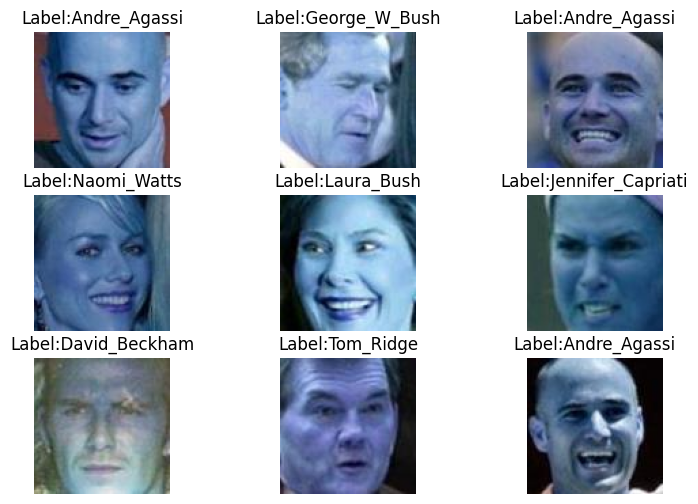

In [ ]:
# Read the names of the celebrities in the dataset (there are 62 celebrities)
name_list = []
with open(labels_dir+'name_list.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        name_list.append(row[1])

# Plot a few images to check if the labels are correct
# There are a few bad images in the dataset, it needs to be cleaned
plt.figure(figsize=(9, 6))
for n in range(9):
    i = np.random.randint(0, len(imgs_train), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(imgs_train[i[0]])
    plt.title('Label:' + str(name_list[labels_train[i[0]]]))
    plt.axis('off')

### Define the Model

We will use a pretrained VGG-16 model, and we will just add a classifier with 3 Dense layers on top of the model to fine-tune it to the LFW dataset.

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import vgg16

import datetime
now = datetime.datetime.now

In [ ]:
def Network():

    base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add fully-connected layers
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    # Add a softmax layer
    predictions = Dense(62, activation='softmax')(x)

    # The model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

Let's define a function for plotting the accuracy and loss called `plot_accuracy_loss`, which we can call with different models to examine the learning curves.

In [ ]:
def plot_accuracy_loss():
    # plot the accuracy and loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1,2,1)
    plt.plot(epochsn, acc, 'b', label='Training Accuracy')
    plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('ACCURACY')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

### Learning rate = 1e-4, Epochs = 10

In Lecture 14, we explained that most NNs employ a version of the Gradient Descent algorithm for updating the network parameters during training, depicted in the figure below. The learning rate determines the size of the updates at each step, i.e., it controls how fast the network parameters are updated.

<img src="images/gradient_descent.png" width="800">

*Figure: Gradient descent algorithm.*


If the learning rate is too small, the algorithm will take many epochs to converge, and it may even get stuck into a local minima. If the learning rate is too high, the algorithm may jump over the best solutions and may not be able to converge to good solutions.

<img src="images/learning_rate.png" width="1000">

*Figure: Impact of the learning rate.* Source: https://www.bdhammel.com/learning-rates/

In the previous lectures, we used the following code to compile the models, which uses the Adam optimizer, but we didn't specify the learning rate of the optimizer. For the implementation of Adam in Keras, the default learning rate is 1e-3.

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

If we would like to use another value for the learning rate, then we will need to import the Adam optimizer, and compile the model with:

    from tensorflow.keras.optimizers import Adam
    model.compile(optimizer=Adam(learning_rate=VALUE),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

The following code trains a model for 10 epochs with a learning rate of `1e-4 = 0.0001`. We have selected this learning rate because we know that it works well for this combination of model and data.

We can see that the model achieved close to 80% accuracy on the test set, and the training took about 3 minutes. From the plots of the accuracy and loss curves, we can tell that 10 epochs are not sufficient for training the model, because at the end of the 10th epoch, the accuracy was still increasing and the loss was decreasing.

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

Training time: 0:02:57.097061
Classification Accuracy:  81.79218173027039


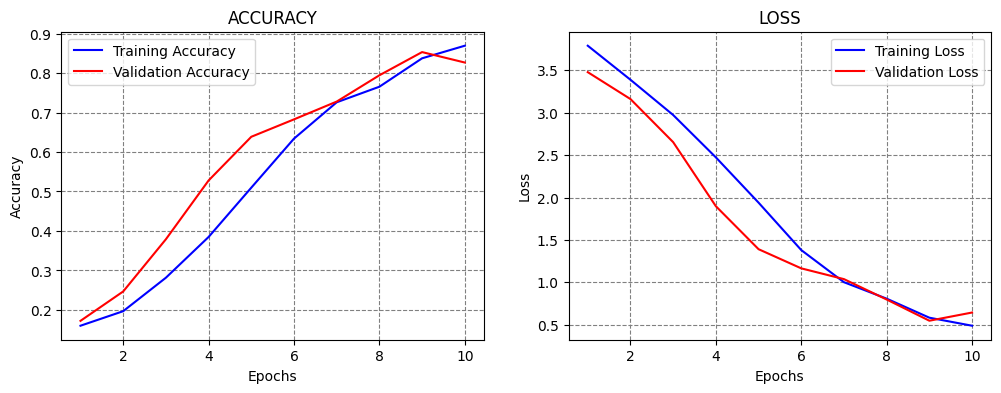

In [ ]:
LEARNING_RATE = 1e-4
EPOCHS_NUM = 10

# create a model
model = Network()

# compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM,
                     validation_data=(imgs_val, labels_val), verbose=0)
print('\nTraining time: %s' % (now() - t))

# evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test, verbose=0)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### Learning rate = 1e-4, Epochs = 30

Let's train the model for 30 epochs using the same learning rate to see if this number of epochs would be sufficient.

From the results below, we can see that the model achieved over 95% accuracy, and the training took about 7 minutes.

Based on the learning curves, at epoch 30 the validation accuracy and loss were converging to a plateau level, and it was unclear if training the model for more than 30 epochs would improve the performance. An alternative is to use Early Stopping callback, so that the training is stopped automatically (e.g., when the validation loss stops decreasing). Such case is shown in a subsequent section.


Training time: 0:07:49.475702
Classification Accuracy:  95.42421102523804


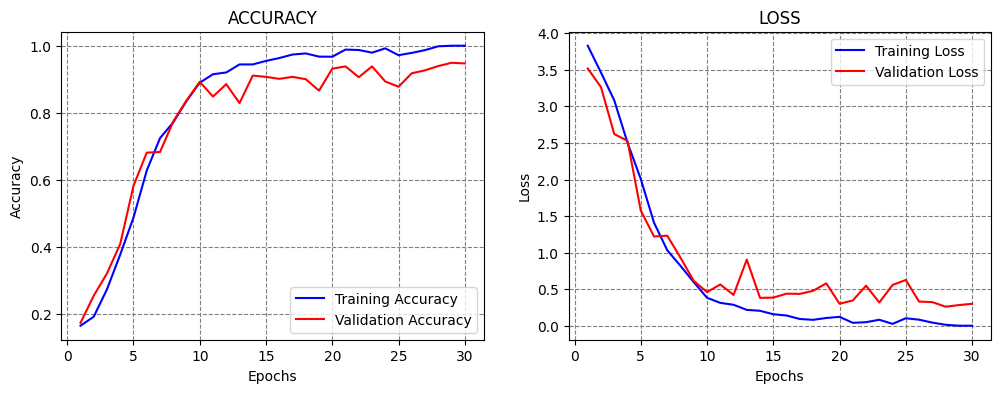

In [ ]:
LEARNING_RATE = 1e-4
EPOCHS_NUM = 30

model = Network()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM,
                     validation_data=(imgs_val, labels_val), verbose=0)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test, verbose=0)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### Learning rate = 1e-3, Epochs = 20

Next, let's try to train the model using different learning rates, for instance, by increasing the learning rate to `1e-3 = 0.001`.

Increasing the learning rate will cause the model to apply larger values for the update of the parameters during the training. We can expect that the training will converge faster, and we can use a smaller number of epochs.

However, large learning rates can cause the model to update the parameters too fast, as in this case. As we can see, the model achieved only 16% accuracy, and the accuracy curves did not improve after that level.


Training time: 0:05:06.832105
Classification Accuracy:  16.873212158679962


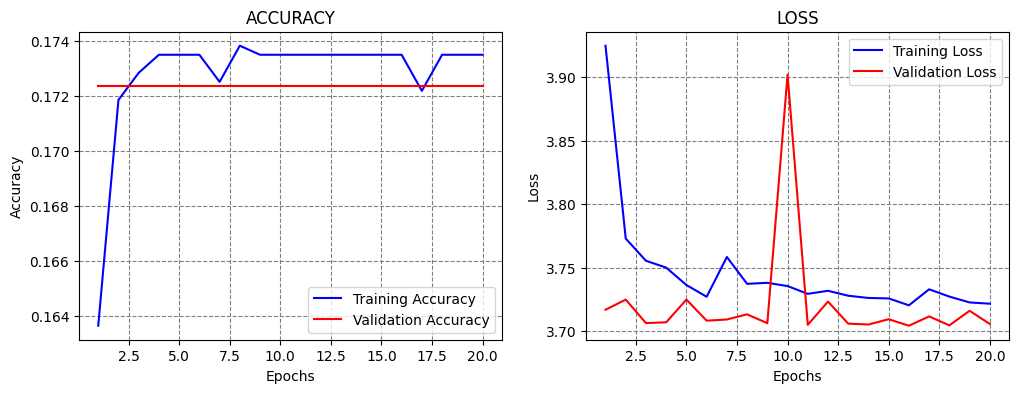

In [ ]:
LEARNING_RATE = 1e-3
EPOCHS_NUM = 20

model = Network()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM,
                     validation_data=(imgs_val, labels_val), verbose=0)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test, verbose=0)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### Learning rate = 1e-2, Epochs = 10

If we increase the learning rate even further to `0.01`, we can expect that training will fail, since we saw that even a learning rate of `0.001` was too high. Based on the learning curves, we can tell that the learning is too fast and too aggressive.


Training time: 0:02:34.354941
Classification Accuracy:  16.873212158679962


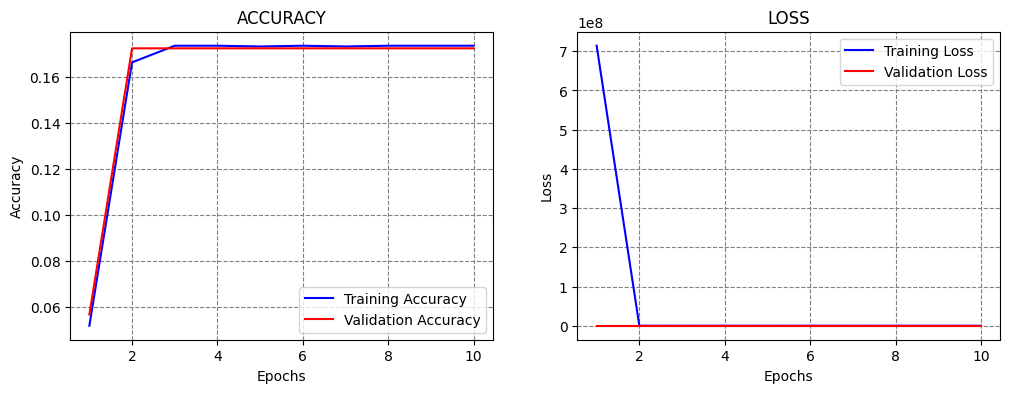

In [ ]:
LEARNING_RATE = 1e-2
EPOCHS_NUM = 10

model = Network()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM,
                     validation_data=(imgs_val, labels_val), verbose=0)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test, verbose=0)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### Learning rate = 1e-5, Epochs = 50

Let's try the opposite case, and reduce the learning rate to `1e-5 = 0.00001`. Smaller learning rates produce smaller updates of the model parameters, and slower learning. This may avoid the problems of learning too fast when large learning rates are used.

This model achieved slightly better accuracy than with the `1e-4` learning rate. Also, the learning curves look good, because the accuracy and loss gradually change, and the validation curves follow the training curves.




Training time: 0:13:05.483821
Classification Accuracy:  93.6129629611969


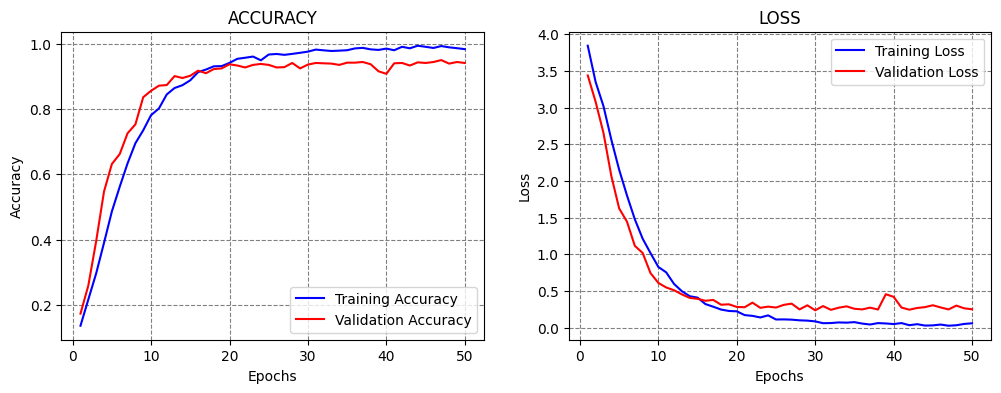

In [ ]:
LEARNING_RATE = 1e-5
EPOCHS_NUM = 50

model = Network()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM,
                     validation_data=(imgs_val, labels_val), verbose=0)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test, verbose=0)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### Learning rate = 1e-6, Epochs = 50

Next, let's reduce the learning rate even further to `1e-6`.

Although smaller learning rates avoid training failure when we use overly large learning rates, using very small learning rates does not necessarily lead to improved performance, since the learning can be too slow.

Based on the learning curves, we can tell that at the end of epoch 50 the model parameters were gradually being updated, and that with this learning rate we would need to train the model for at least 200 or 300 epochs to reach convergence, or maybe even more.


Training time: 0:13:00.788946
Classification Accuracy:  71.21067643165588


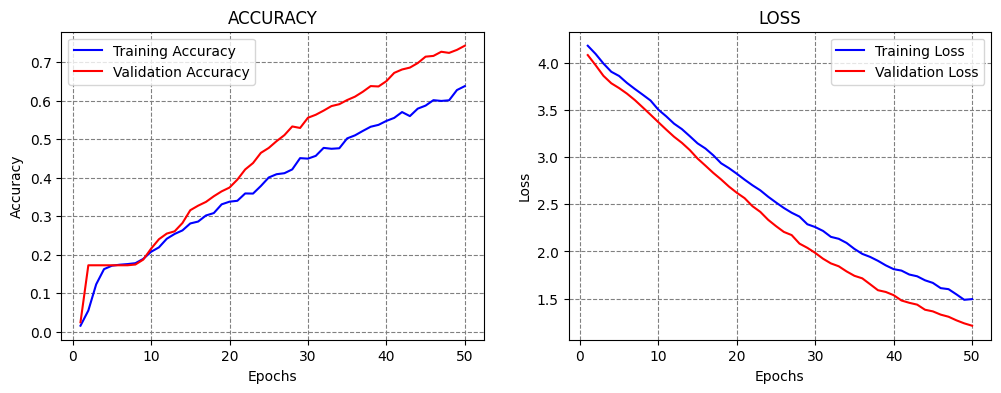

In [ ]:
LEARNING_RATE = 1e-6
EPOCHS_NUM = 50

model = Network()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM,
                     validation_data=(imgs_val, labels_val), verbose=0)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test, verbose=0)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

There are also several libraries developed for estimating the learning rate of NNs. These tools change the learning rate in a range of values, typically starting with a very small learning rate and increasing it to a high learning rate. The model is trained and evaluated only for a few epochs using different learning rates. Based on a plot of the loss for different learning rates, these tools can help to find a suitable learning rate, that can afterward be used to fully train the model. However, although such tools can identify a range of suitable values for the learning rate, they should be used with caution, and the users should still run candidate models in the suggested range to fully evaluate the model performance.

## 16.3 Callbacks <a name='16.3-callbacks'></a>

In the lecture  on ConvNets we mentioned that callbacks can be used to monitor the model performance and take certain actions. The next section provides additional examples of applying callbacks in Keras.

### 16.3.1 Early Stopping <a name='16.3.1-early-stopping'></a>

As we know, using **Early Stopping** callback is often beneficial, since we don't need to guess the optimal number of epochs to train the model. Instead, the callback will terminate the training when a selected metric is not improving. In the next cell, we specified to stop the training when the validation loss does not improve for 20 epochs (the `patience` argument). We set the `EPOCHS_NUM` argument to 1000, although we know that the model will terminate after about 50-60 epochs. Therefore, the number of epochs is not very important when we use this callback, it only needs to be large enough so that the training is not stopped prematurely.

This model achieved over 94% accuracy. Notice also in the accuracy curve that the accuracy in one of the latest epochs dropped a lot. We will see next how to handdle that case by using CheckPoint callback.


Training time: 0:21:56.945756
Classification Accuracy:  92.56434440612793


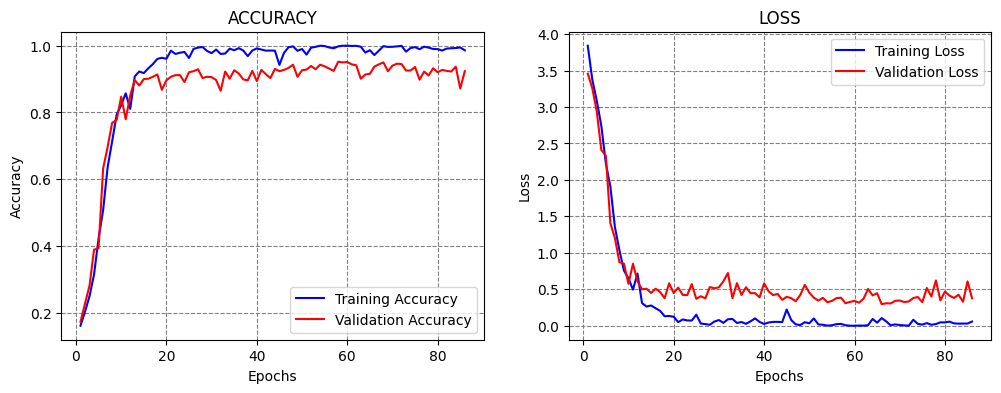

In [ ]:
LEARNING_RATE = 1e-4
EPOCHS_NUM = 1000

model = Network()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
callbacks = [EarlyStopping(monitor='val_loss', patience=20)]
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM,
                     validation_data=(imgs_val, labels_val), verbose=0, callbacks=callbacks)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test, verbose=0)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### 16.3.2 Save CheckPoint <a name='16.3.2-save-checkpoint'></a>

**CheckPoint** callback saves a checkpoint of the model (i.e., the model parameters) after every epoch when a monitored metric does not improve. We set the metrics to be the validation loss, and the values of the model parameters will be saved at the specified `filepath`. This can be useful if training the model takes hours, where if something goes wrong, we can just resume the training from a checkpoint.

We choose to set `verbose=1` for the callback, to output the epochs at which a checkpoint is saved.

At the beginning of the training, the checkpoint will be saved after every epoch, and after the model reaches a plateau, a new checkpoint will be saved only when there is an improvement in the performance, by overwriting the latest checkpoint.



Epoch 1: val_loss improved from inf to 3.63002, saving model to sample_data/model_celeb.weights.h5

Epoch 2: val_loss improved from 3.63002 to 3.14162, saving model to sample_data/model_celeb.weights.h5

Epoch 3: val_loss improved from 3.14162 to 2.69129, saving model to sample_data/model_celeb.weights.h5

Epoch 4: val_loss improved from 2.69129 to 2.38674, saving model to sample_data/model_celeb.weights.h5

Epoch 5: val_loss improved from 2.38674 to 1.86158, saving model to sample_data/model_celeb.weights.h5

Epoch 6: val_loss improved from 1.86158 to 1.60096, saving model to sample_data/model_celeb.weights.h5

Epoch 7: val_loss improved from 1.60096 to 1.30128, saving model to sample_data/model_celeb.weights.h5

Epoch 8: val_loss improved from 1.30128 to 1.01901, saving model to sample_data/model_celeb.weights.h5

Epoch 9: val_loss improved from 1.01901 to 0.90223, saving model to sample_data/model_celeb.weights.h5

Epoch 10: val_loss improved from 0.90223 to 0.66062, saving model t

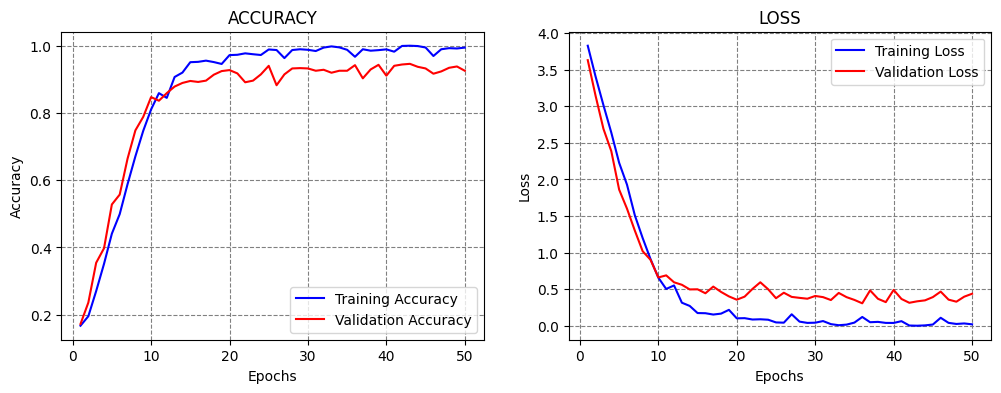

In [ ]:
LEARNING_RATE = 1e-4
EPOCHS_NUM = 50

model = Network()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
callbacks = ModelCheckpoint(filepath='sample_data/model_celeb.weights.h5', monitor='val_loss', mode='min',
                            save_weights_only=True, save_best_only=True, verbose=1)
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM,
                     validation_data=(imgs_val, labels_val), verbose=0, callbacks=[callbacks])
print('Training time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test, verbose=0)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### 16.3.3 Reduce Learning Rate On Plateau <a name='16.3.3-reduce-learning-rate-on-plateau'></a>

**ReduceLROnPlateau** stands for Reduce Learning Rate on Plateau. It is another very useful callback, since prior works have reported that training models generally benefits from using larger learning rate at the beginning of the training, and gradually reducing the learning rate when the training does not improve.

This is exactly what this callback does. In the next cell, the learning rate is initially set to `1e-4=0.0001`. ReduceLROnPlateau has a patience of 10 epochs, factor of 0.1, and minimum learning rate of `1e-6`. This means that when the monitored metric (in this case, the validation loss) does not reduce for 10 epochs, the learning rate will be multiplied by the `factor` and become `1e-5`. When the model stops improving again, the learning rate will be again multiplied by the factor and become `1e-6`. Since this is the minimum value for the learning rate, we will combine this callback with Early Stopping to terminate the training. Note that the patience value for Early Stopping was set longer than the patience for ReduceLROnPlateau.



Epoch 50: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 60: ReduceLROnPlateau reducing learning rate to 1e-06.

Training time: 0:15:24.325223
Classification Accuracy:  95.71020007133484


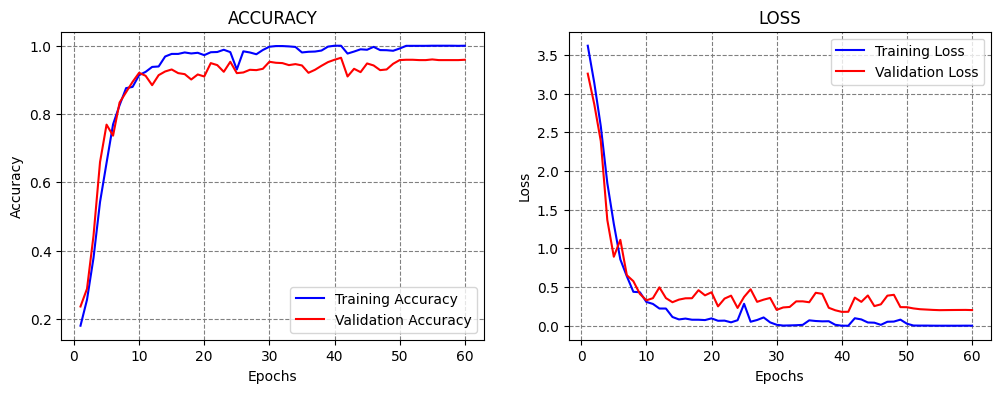

In [ ]:
LEARNING_RATE = 1e-4
EPOCHS_NUM = 1000

model = Network()
model.compile(optimizer=Adam(learning_rate = LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
callbacks = [EarlyStopping(monitor='val_loss', patience = 20),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6, verbose=1)]
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM,
                     validation_data=(imgs_val, labels_val), verbose=0, callbacks=callbacks)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test, verbose=0)
print("Classification Accuracy: ", 100*evals_test[1])


# plot the accuracy and loss
plot_accuracy_loss()

### 16.3.4 Learning Rate Scheduler <a name='16.3.4-learning-rate-scheduler'></a>

In the previous examples, we mostly used models with a constant learning rate, except in the ReduceLROnPlateau case where the callback reduced the learning rate automatically based on certain criteria (e.g., when the validation loss plateaued).

**Learning Rate Scheduler** allows to define custom schedulers that change the learning rate during training. This process of gradually reducing the learning rate over time is conceptually similar to annealing in metallurgy, which refers to heating and slowly cooling a metal to make it stronger or less brittle. Thus, reducing the learning rate is sometimes referred to as **annealing**, because the model is "cooled down" to refine its parameters and achieve better convergence.

Popular learning rate schedules are shown in the figure below:

- Time-based decay: reduces the learning rate continuously according to a simple time-based function that gradually slows learning over time.
- Step decay: keeps the learning rate constant for a set number of epochs, then drops it by a fixed factor at specified intervals, creating a staircase pattern.
- Exponential decay: decreases the learning rate exponentially with training steps or epochs, leading to a smooth and rapid reduction early in training.
- Cosine decay: follows a cosine-shaped curve that smoothly lowers the learning rate toward zero.
- Linear decay: linearly decreases the learning rate from its initial value to a minimum value across the total training duration.
- Polynomial decay: reduces the learning rate following a polynomial function of the current step, allowing fine control over the decay shape and final value. In the figure, power is the exponent of the polynomial function that controls the shape of the decay curve (e.g., power = 1 corresponds to linear decay schedule).
- Warm-up: starts training with a small learning rate and gradually increases it for the first few steps or epochs to prevent instability from large initial updates. Warm-up can be combined with any of the above decay functions to reduce the learning rate after reaching the target value. The warm-up phase is relatively short, with the typical number of warm-up steps ranging between 1% and 5% of the total training steps.

<img src='images/lr_schedulers.png' width=1000px/>

The following sections present codes that implement three of the above-listed learning rate schedulers.

### Time-based Decay

This scheduler decreases the learning rate in each epoch by a given fixed amount. An example is shown in the next figure, where a model is trained for 100 epochs, and the learning rate is gradually reduced from 0.01 in the first epoch to 0.006 in the last epoch.

<img src="images/time_based_decay.png" width="500">

*Figure: Time-based decay.*

The implementation is shown below, where the Learning Rate Scheduler callback accepts a function which defines the schedule for the learning rate. The function `lr_time_based_decay` applies the `decay` amount at each epoch, where `lr` is the learning rate from the previous epoch. The value of the decay is usually set as the quotient of the initial learning rate and the number of epochs.


Training time: 0:25:26.746135
Classification Accuracy:  94.85223889350891


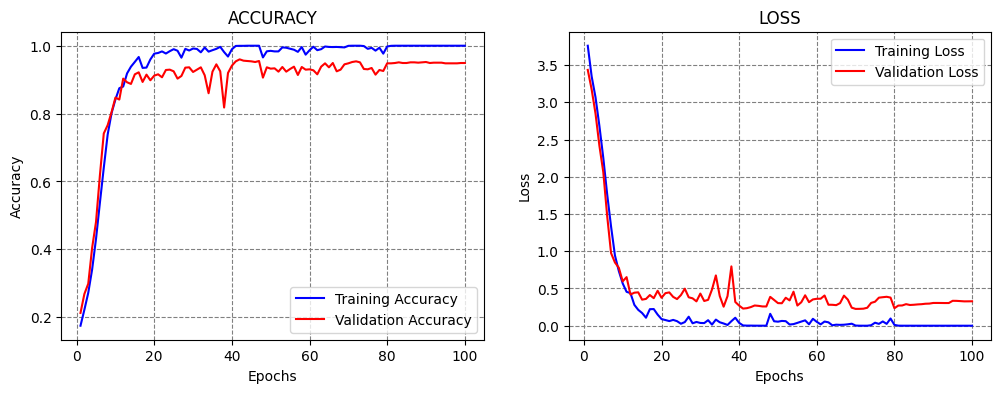

In [ ]:
INITIAL_LEARNING_RATE = 1e-4
EPOCHS_NUM = 100
decay = INITIAL_LEARNING_RATE / EPOCHS_NUM

def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

model = Network()
model.compile(optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
callbacks = [LearningRateScheduler(lr_time_based_decay, verbose=0)]
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM,
                     validation_data=(imgs_val, labels_val), verbose=0, callbacks=callbacks)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test, verbose=0)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### Step Decay

Step decay scheduler decreases the learning rate for a fixed amount after a number of training epochs. An example is shown in the figure, where the learning rate is reduced by half every 10 epochs.

<img src="images/step_decay.png" width="500">

*Figure: Step decay.*

In the next cell, step decay is applied with the function `lr_step_decay`, where `drop_rate` is the reduced ratio of the initial learning rate at each step, and `epochs_drop` is set to 15 epochs.


Training time: 0:12:53.993934
Classification Accuracy:  93.32697987556458


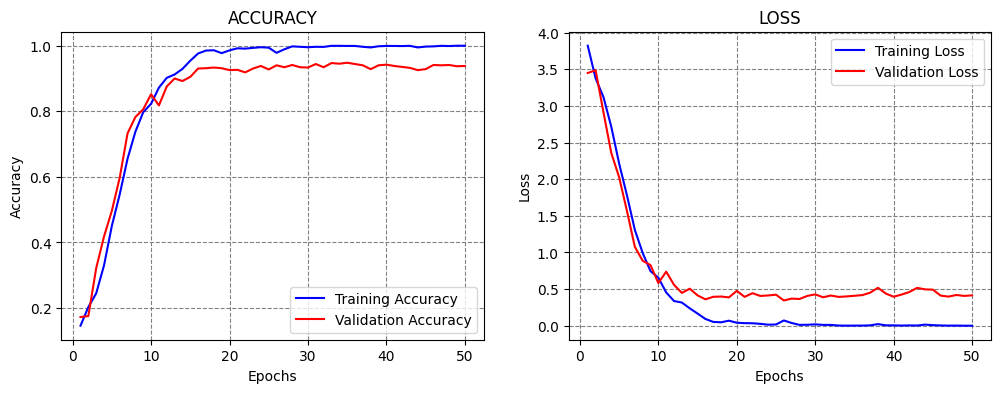

In [ ]:
import math

INITIAL_LEARNING_RATE = 1e-4
EPOCHS_NUM = 50

def lr_step_decay(epoch):
    drop_rate = 0.5
    epochs_drop = 15
    return INITIAL_LEARNING_RATE * math.pow(drop_rate, math.floor(epoch/epochs_drop))

model = Network()
model.compile(optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
callbacks = [LearningRateScheduler(lr_step_decay, verbose=0)]
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM,
                     validation_data=(imgs_val, labels_val), verbose=0, callbacks=callbacks)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test, verbose=0)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

### Exponential Decay

The scheduler decreases the learning rate at an exponential rate. In the cell below `k` is the rate of exponential decay.

<img src="images/exponential_decay.png" width="500">

*Figure: Exponential decay.*




Training time: 0:12:57.172125
Classification Accuracy:  92.65967607498169


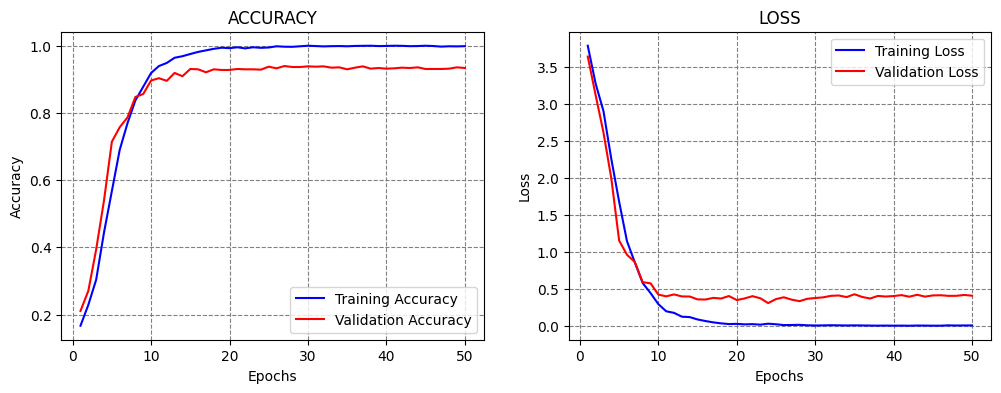

In [ ]:
INITIAL_LEARNING_RATE = 1e-4
EPOCHS_NUM = 50

def lr_exp_decay(epoch):
    k = 0.1
    return INITIAL_LEARNING_RATE * math.exp(-k*epoch)

model = Network()
model.compile(optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# fit model
t = now()
callbacks = [LearningRateScheduler(lr_exp_decay, verbose=0)]
history = model.fit(imgs_train, labels_train, batch_size=32, epochs=EPOCHS_NUM,
                     validation_data=(imgs_val, labels_val), verbose=0, callbacks=callbacks)
print('\nTraining time: %s' % (now() - t))

# Evaluate on test data
evals_test = model.evaluate(imgs_test, labels_test, verbose=0)
print("Classification Accuracy: ", 100*evals_test[1])

# plot the accuracy and loss
plot_accuracy_loss()

## 16.4 Grid Search <a name='16.4-grid-search'></a>

Applying **Grid Search** over the hyperparameters of neural networks that have long training times can be prohibitively computationally expensive. On the other hand, when working with smaller datasets and models, applying Grid Search for some of the hyperparameters can be an option.

This section presents a simple Grid Search over two hyperparameters in the model: number of neurons in the first Dense layer, and the batch size. We can simply write a function that takes as arguments these two hyperparameters, as in the next cell. Afterward, we can create a for-loop and train and evaluate a model for each combination of the values for the selected hyperparameters.

We examined 3 values for the number of neurons and 3 values for the batch size, resulting in 9 models. The results indicate that the model with 1,024 neurons and 128 batch size achieved the best performance. Consider that training each model took about 10 minutes, and evaluating 9 models took about 1.5 hours. Tuning a large number of hyperparameters over several different values can take a long time.


In [ ]:
def Network(neurons_per_layer, batch_size):

    base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add dense layers
    x = Dense(neurons_per_layer, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    # Add a softmax layer
    predictions = Dense(62, activation='softmax')(x)

    # The model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile
    model.compile(optimizer=Adam(learning_rate=1e-4), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    # Fit
    model.fit(imgs_train, labels_train, batch_size=batch_size, epochs=30,
                     validation_data=(imgs_val, labels_val), verbose=0)

    # Evaluate on test data
    _, test_acc = model.evaluate(imgs_test, labels_test, verbose=0)

    return test_acc

In [ ]:
neurons_per_layers = [512, 1024, 2048]
batch_sizes = [32, 64, 128]

for number_neurons in neurons_per_layers:
    for batch_size in batch_sizes:
        acc = Network(number_neurons, batch_size)
        print(f"\nNumber of neurons: {number_neurons:<9} Batch size: {batch_size:<9} Test accuracy: {acc*100:6.3f}%")


Number of neurons: 512       Batch size: 32        Test accuracy: 91.802%

Number of neurons: 512       Batch size: 64        Test accuracy: 94.280%

Number of neurons: 512       Batch size: 128       Test accuracy: 94.566%

Number of neurons: 1024      Batch size: 32        Test accuracy: 92.946%

Number of neurons: 1024      Batch size: 64        Test accuracy: 93.327%

Number of neurons: 1024      Batch size: 128       Test accuracy: 94.090%

Number of neurons: 2048      Batch size: 32        Test accuracy: 87.607%

Number of neurons: 2048      Batch size: 64        Test accuracy: 93.899%

Number of neurons: 2048      Batch size: 128       Test accuracy: 94.566%


## 16.5 Keras Tuner <a name='16.5-keras-tuner'></a>

There are several libraries developed for tuning the hyperparameters of neural networks. One is the **Keras Tuner** for tuning Keras models.

The Keras Tuner is somewhat similar to the Grid Search and Random Search in scikit-learn, and allows to define the search space for the hyperparameters over which the model will be fit, and it returns an optimal set of hyperparameters.

Keras Tuner is not part of the `Keras` package and it needs to be installed and imported.

In [ ]:
pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

### Load Fashion MNIST Dataset

To demonstrate the use of the Keras Tuner we will work with the Fashion MNIST dataset.

In [ ]:
(img_train, label_train), (img_test, label_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Model Builder

In the cell below, a function called `model_builder` is created, which performs search over two hyperparameters:

- Number of neurons in the first Dense layer,
- Learning rate.

In the code, `hp` is an instance of the HyperParameters class provided by Keras Tuner. The line `hp_units = hp.Int('units', min_value=32, max_value=512, step=32)` defines a grid search for the number of neurons in the Dense layer in the range [32, 64, 96, ..., 512].

Next, a grid search for the learning rate is defined in the range `[1e-2, 1e-3, 1e-4]`.

In [ ]:
def model_builder(hp):
    # Define the input layer with the given shape
    inputs = Input(shape=(28, 28))

    # Flatten the input
    x = Flatten()(inputs)

    # Tune the number of units in the Dense layer, choosing between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    x = Dense(units=hp_units, activation='relu')(x)

    # Output layer with 10 units
    outputs = Dense(10, activation='softmax')(x)

    # Create the model using the functional API
    model = Model(inputs=inputs, outputs=outputs)

    # Tune the learning rate for the optimizer, choosing from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

### Hyperparameter Tuning

The Keras Tuner has four tuning algorithms available:

- RandomSearch Tuner, similar to Randomized Grid in scikit-learn performs a random search over a distribution of values for the hyperparameters.
- Hyperband Tuner, trains a large number of models for a few epochs and carries forward only the top-performing half of models to the next round, to converge to a high-performing model.
- BayesianOptimization Tuner, performs BayesianOptimization by creating a probabilistic mapping of the model to the loss function, and iteratively evaluating promising sets of hyperparameters.
- Sklearn Tuner, designed for use with scikit-learn models.

In the next cell, the Hyperband tuner is used, which has as the arguments the model, objective (metric to monitor), maximum number of epochs for each configuration of hyperparameters (training will be stopped for the worst-performing configurations after this number of epochs), and factor (used to search for top-performing models, e.g., a reduction factor of 3 means that one third of the configurations will be kept for the next iteration, and the rest of the configurations will be eliminated).

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3)

In [ ]:
tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Trial 30 Complete [00h 00m 37s]
val_accuracy: 0.8877500295639038

Best val_accuracy So Far: 0.8915833234786987
Total elapsed time: 00h 08m 29s


In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Optimal number of neurons in the Dense layer: {best_hps.get('units')}")
print (f"Optimal learning rate: {best_hps.get('learning_rate')}")

Optimal number of neurons in the Dense layer: 320
Optimal learning rate: 0.001


### Train and Evaluate the Model

Next, we will use the optimal hyperparameters from the Keras Tuner to create a model, and afterward we will evaluate the accuracy on the test dataset.


In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
model.fit(img_train, label_train, epochs=50, validation_split=0.2, verbose=0)

eval_result = model.evaluate(img_test, label_test, verbose=0)
print("[test loss, test accuracy]:", eval_result)

[test loss, test accuracy]: [0.6281461119651794, 0.8830000162124634]


Other libraries that perform model selection, hyperparameter tuning, and neural architecture search include [AutoKeras](https://autokeras.com/), [auto-sklearn](https://github.com/automl/auto-sklearn), [Optuna](https://optuna.org/), [Auto-PyTorch](https://github.com/automl/Auto-PyTorch) and [Ray Tune](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) for PyTorch, [AutoWEKA](https://www.cs.ubc.ca/labs/algorithms/Projects/autoweka/), [Weights & Biases](https://wandb.ai/site/), and others.


## 16.6 AutoML <a name='16.6-autoML'></a>

**AutoML** or Automated Machine Learning refers to tools and libraries that are designed to allow non-ML experts to build Machine Learning systems and solve Data Science tasks without extensive knowledge in these fields.

AutoML systems range from automated *No Code* ML solutions that allow the end-users to just drag-and-drop their data, or *Low Code* systems that automate ML steps with minimal coding efforts, to systems that require coding experience and are designed to increase the efficiency of data scientists by automating hyperparameter tuning and architecture search.

Most large providers of cloud computing and ML services typically provide some form of AutoML services. Examples include [Google AutoML](https://cloud.google.com/automl), [Microsoft Azure AutoML](https://azure.microsoft.com/en-us/products/machine-learning/automatedml/#overview), [Amazon SageMaker](https://aws.amazon.com/sagemaker/), etc.

In a subsequent lecture on training and deploying models on the Cloud, we will present examples of training ML models using No Code and Low Code modes with Microsoft Azure ML.





## References <a name='references'></a>

1. TensorFlow - ML Basics with Keras, Introduction to the Keras Tuner, available at [https://www.tensorflow.org/tutorials/keras/keras_tuner#:~:text=The%20Keras%20Tuner%20is%20a,called%20hyperparameter%20tuning%20or%20hypertuning](https://www.tensorflow.org/tutorials/keras/keras_tuner#:~:text=The%20Keras%20Tuner%20is%20a,called%20hyperparameter%20tuning%20or%20hypertuning).
2. Keras Learning Rate Finder, available at [https://github.com/surmenok/keras_lr_finder](https://github.com/surmenok/keras_lr_finder).
3. Learning Rate Schedule in Practice: an example with Keras and TensorFlow 2.0, B. Chen, available at [https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c](https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c).
4. AutoML.org Freiburg-Hannover, AutoML, available at [https://www.automl.org/automl/](https://www.automl.org/automl/).

[BACK TO TOP](#top)